<a href="https://colab.research.google.com/github/guilhermegfv/sprint_analisededados/blob/main/Notebook/MVP_AnaliseDeDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUÇÃO

MEIOS DE PAGAMENTO

A entrada do PIX como modalidade de pagamento para os brasileiros é uma iniciativa recente e benéfica para ambos lados. Pelo lado da empresa, representa a menor tarifa de arrecadação a ser paga a instituição bancária, além de contribuir na digitalização do cliente. O objetivo deste projeto, como subsídio para análises internas da área de operação onde trabalho, é entender o crescimento do PIX e como devem ser atribuídas as metas de crescimento para o fim de 2024 e 2025.

FONTE BANCO CENTRAL DADOS ABERTOS

A fonte primária para estudo deste projeto será do próprio governo federal, onde em seu repositório de dados abertos possui uma base de dados com quantidades de transações e montantes somados por modalidade, mês a mês. Assim, será estudado o percentual do uso do PIX pelos brasileiros e alguns padrões de preferência.

DESAFIOS

Qual a projeção de crescimento do PIX para 2024 e 2025?

Quão impactante é o ticket médio da transação para escolha da modalidade pelo cliente?

Quais modalidades se mantiveram constante e quais decaíram com o surgimento do PIX?

# IMPORTAR E TRANSFORMAÇÕES

## IMPORTAR

IMPORTAR BIBLIOTECAS

Começaremos importando todas as bibliotecas necessárias neste projeto: pandas, matplotlib.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

FONTE ESTATÍSTICAS DE MEIOS DE PAGAMENTO

A partir desta fonte, serão carregados os dados utilizando o próprio pandas:

https://dadosabertos.bcb.gov.br/dataset/estatisticas-meios-pagamentos

É importante ressaltar que na consulta, o valor 'quantidade' está em milhares e o valor 'valor' está em milhões.

In [2]:
url = "https://olinda.bcb.gov.br/olinda/servico/MPV_DadosAbertos/versao/v1/odata/MeiosdePagamentosMensalDA(AnoMes=@AnoMes)?@AnoMes='202001'&$top=10000&$format=text/csv&$select=AnoMes,quantidadePix,valorPix,quantidadeTED,valorTED,quantidadeTEC,valorTEC,quantidadeCheque,valorCheque,quantidadeBoleto,valorBoleto,quantidadeDOC,valorDOC"
df = pd.read_csv(url)
print(df.head())


   AnoMes quantidadePix    valorPix quantidadeTED    valorTED quantidadeTEC  \
0  202408    5662277,51  2431073,49      67581,13  3621022,65             0   
1  202407    5418345,45  2417940,73      69657,15  3828948,82             0   
2  202406    5278880,88  2179182,85      63599,32  3527912,28             0   
3  202405    5229864,01  2138902,46      69023,11  3482036,97             0   
4  202404    4924838,48  2084927,51      70647,15  3652606,48             0   

  valorTEC quantidadeCheque valorCheque quantidadeBoleto valorBoleto  \
0        0         10009,39    39142,87        343924,99   519248,33   
1        0          10942,8    41504,78        366484,15   546660,21   
2        0          9642,76    36114,74        327754,93   475278,61   
3        0         10467,85    40133,55        349180,92   506302,82   
4        0         11179,22     43295,4        361633,28   524619,69   

  quantidadeDOC valorDOC  
0             0        0  
1             0        0  
2          

## TRANSFORMAÇÕES

TRANSFORMAÇÕES

1) Será corrigida a coluna AnoMes, no format integer YYYYMM para MM/YYYY em date format para correto uso em gráficos

2) Depois, será dividido em dois dataframes, um utilizando quantidade utilizada, e o segundo apenas para tratar montante total.

3) Para cada um desses dois dataframes, será calculado uma coluna com percentual de cada método de pagamento, mês a mês

4) Será criado um terceiro dataframe com o valor de ticket médio, isto é, valor por transação média de cada método de pagamento, mês a mês

In [3]:
df.sort_values(by='AnoMes', inplace=True) #ranqueamento em ordem crescente para a primeira linha ser o mês mais antigo e os gráficos serem plotados em cronologia crescente
df['AnoMes'] = df['AnoMes'].astype(str)
df['date'] = pd.to_datetime(df['AnoMes'], format='%Y%m')
df['MesAno'] = df['date'].dt.strftime('%m/%Y') #transformação dos meses do formato 202001 para 01/2020 afim de organizar as informações nas plotagens
df.drop(['date', 'AnoMes'], axis=1, inplace=True) #drop das colunas criadas para suporte
df.reset_index(drop=True, inplace=True) #reorganização do índice de forma crescente

In [4]:
print(df.columns)

Index(['quantidadePix', 'valorPix', 'quantidadeTED', 'valorTED',
       'quantidadeTEC', 'valorTEC', 'quantidadeCheque', 'valorCheque',
       'quantidadeBoleto', 'valorBoleto', 'quantidadeDOC', 'valorDOC',
       'MesAno'],
      dtype='object')


In [5]:
df_quantidade = df[['MesAno','quantidadePix','quantidadeTED','quantidadeTEC','quantidadeCheque','quantidadeBoleto','quantidadeDOC']]
df_valor = df[['MesAno','valorPix','valorTED','valorTEC','valorCheque','valorBoleto','valorDOC']]

In [6]:
print(df_quantidade.dtypes)

MesAno              object
quantidadePix       object
quantidadeTED       object
quantidadeTEC       object
quantidadeCheque    object
quantidadeBoleto    object
quantidadeDOC       object
dtype: object


Inicialmente, porque a base de dados vem com o caractere ',' nos números decimais, o python entende como object (string) e não é capaz de fazer operações. Portanto, aplicamos uma função apply lambda em todas as colunas (exceto a coluna MesAno) para substituir o ',' por '.' e depois, transformar em float. Geramos o print no df_quantidade para conferir a transformação das colunas desejadas.

In [7]:
df_quantidade = df_quantidade.apply(lambda col: col.astype(str).str.replace(',', '.').astype(float) if col.name != 'MesAno' else col)
df_valor = df_valor.apply(lambda col: col.astype(str).str.replace(',', '.').astype(float) if col.name != 'MesAno' else col)

# A função apply lambda garante que a regra seja aplicada em todas as colunas. O if no final da função cria a exceção para a coluna MesAno que não deve ser afetada.
# Esta função corrigirá os valores decimais, substituindo a virgula pelo ponto, para que o python corretamente leia o valor decimal e transforme o object em float.

In [8]:
print(df_quantidade.dtypes)

MesAno               object
quantidadePix       float64
quantidadeTED       float64
quantidadeTEC       float64
quantidadeCheque    float64
quantidadeBoleto    float64
quantidadeDOC       float64
dtype: object


Agora serão geradas as colunas com soma total por mês e depois os percentuais método a método.

In [9]:
df_quantidade['quantidadeTotal'] = df_quantidade.iloc[:, 1:].sum(axis=1)
df_valor['valorTotal'] = df_valor.iloc[:, 1:].sum(axis=1)

#criação de coluna em amboas dataframes com valores somados de todas as outras colunas (exceto o mês-ano)

In [10]:
df_quantidade['percPix'] = df_quantidade['quantidadePix'] / df_quantidade['quantidadeTotal'] * 100
df_quantidade['percTED'] = df_quantidade['quantidadeTED'] / df_quantidade['quantidadeTotal'] * 100
df_quantidade['percTEC'] = df_quantidade['quantidadeTEC'] / df_quantidade['quantidadeTotal'] * 100
df_quantidade['percCheque'] = df_quantidade['quantidadeCheque'] / df_quantidade['quantidadeTotal'] * 100
df_quantidade['percBoleto'] = df_quantidade['quantidadeBoleto'] / df_quantidade['quantidadeTotal'] * 100
df_quantidade['percDOC'] = df_quantidade['quantidadeDOC'] / df_quantidade['quantidadeTotal'] * 100

df_valor['percPix'] = df_valor['valorPix'] / df_valor['valorTotal'] * 100
df_valor['percTED'] = df_valor['valorTED'] / df_valor['valorTotal'] * 100
df_valor['percTEC'] = df_valor['valorTEC'] / df_valor['valorTotal'] * 100
df_valor['percCheque'] = df_valor['valorCheque'] / df_valor['valorTotal'] * 100
df_valor['percBoleto'] = df_valor['valorBoleto'] / df_valor['valorTotal'] * 100
df_valor['percDOC'] = df_valor['valorDOC'] / df_valor['valorTotal'] * 100

#criação das colunas de percentual para cada modaliadde em relação ao total por mês.

Vamos criar agora o df_ticket para cálculo dos valores médios por transação.

As colunas de valores estão sendo multiplicadas pro 1000 para nivelamento das variáveis. As quantidades estavam originalmente em milhares e os valores em milhões, portanto faremos a operação com ambas colunas em milhares para se obter o ticket médio correto por operação.

In [11]:
df_ticket = pd.DataFrame(index=df_quantidade.index)
df_ticket['MesAno'] = df_quantidade['MesAno']
df_ticket['ticketPIX'] = (df_valor['valorPix'] *1000)/ df_quantidade['quantidadePix']
df_ticket['ticketTED'] = (df_valor['valorTED'] *1000)/ df_quantidade['quantidadeTED']
df_ticket['ticketTEC'] = (df_valor['valorTEC'] *1000)/ df_quantidade['quantidadeTEC']
df_ticket['ticketCheque'] = (df_valor['valorCheque'] *1000)/ df_quantidade['quantidadeCheque']
df_ticket['ticketBoleto'] = (df_valor['valorBoleto'] *1000)/ df_quantidade['quantidadeBoleto']
df_ticket['ticketDOC'] = (df_valor['valorDOC'] *1000)/ df_quantidade['quantidadeDOC']
df_ticket['ticketTotal'] = (df_valor['valorTotal'] *1000)/ df_quantidade['quantidadeTotal']
df_ticket = df_ticket.apply(lambda col: col.fillna(0))

#criação do dataframe df_ticket com o mesmo índice dos meses dos outros dataframes.
#criação de coluna modalidade a modalidade com o ticket médio por transação, isto é, valor financeiro médio transacionado em cada movimentação financeira.
#a multiplicação do numerador por 1000 aconteceu para nivelar as variáveis em termos de notação científica.

In [12]:
df_ticket.head()

,MesAno,ticketPIX,ticketTED,ticketTEC,ticketCheque,ticketBoleto,ticketDOC,ticketTotal
0,01/2020,0.0,19802.490625,1973.085609,2259.561304,1149.463497,732.425996,5962.456992
1,02/2020,0.0,18429.208695,2014.318486,2208.347458,1113.092564,690.404348,5674.983067
2,03/2020,0.0,22087.255733,2011.016711,2094.886957,1089.789953,687.881016,6801.888019
3,04/2020,0.0,17727.469233,2017.423821,2119.887258,993.598493,658.283416,5665.471477
4,05/2020,0.0,15814.963314,2058.042424,2453.943105,954.657326,699.015081,5238.684236


## DESCRIÇÃO DAS VARIÁVEIS

Vamos analisar estatísticamente os três dataframes e entender os valores encontrados.

In [13]:
df_quantidade.describe()

,quantidadePix,quantidadeTED,quantidadeTEC,quantidadeCheque,quantidadeBoleto,quantidadeDOC,quantidadeTotal,percPix,percTED,percTEC,percCheque,percBoleto,percDOC
count,5.600000e+01,56.000000,56.000000,56.000000,56.000000,56.000000,5.600000e+01,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,2.063684e+06,99349.803393,618.558036,16412.575536,337994.586071,8032.688929,2.526093e+06,62.331685,9.718982,0.056249,1.574358,25.196305,1.122422
std,1.784294e+06,35235.870846,288.017066,4396.348016,28260.341262,7763.718966,1.760871e+06,34.659235,11.034925,0.058229,1.766915,20.445111,1.696007
min,0.000000e+00,63599.320000,0.000000,9642.760000,253409.500000,0.000000,3.950150e+05,0.000000,1.110839,0.000000,0.164525,5.653134,0.000000
25%,3.604609e+05,74208.122500,570.855000,12869.467500,329890.240000,2571.360000,8.548693e+05,42.046496,1.931256,0.016944,0.339263,9.219749,0.080659
50%,1.760780e+06,86679.625000,678.250000,15977.450000,344579.675000,5135.905000,2.218036e+06,79.374746,3.849694,0.030160,0.721342,15.774225,0.246500
75%,3.355910e+06,111146.237500,751.252500,18768.682500,357181.505000,11018.802500,3.796510e+06,88.387274,13.898626,0.079493,2.386855,40.571308,1.017578
max,5.662278e+06,193914.690000,1305.510000,27729.480000,380679.530000,29095.160000,6.083793e+06,93.071501,33.872498,0.202480,6.536114,64.237121,6.037091


A contagem de 56 está no número de meses observados.
Os valores de desvio padrão podem nos antecipar o quanto a modalidade variou conforme o passar desses quase 5 anos de estudo.
Além disso, a representação de mínimo, máximo e os 3 quartis.
Nas modalidades Pix, TEC e DOC podemos perceber meses onde nenhuma transação foi identificada.
Além disso, o PIX aparece com grande volume de transações únicas identificadas.

In [14]:
df_valor.describe()

,valorPix,valorTED,valorTEC,valorCheque,valorBoleto,valorDOC,valorTotal,percPix,percTED,percTEC,percCheque,percBoleto,percDOC
count,5.600000e+01,5.600000e+01,56.000000,56.000000,56.000000,56.000000,5.600000e+01,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,8.955614e+05,3.092042e+06,1327.032857,49004.733750,427214.855714,6137.927321,4.471288e+06,17.007918,71.692079,0.033729,1.216163,9.866197,0.183914
std,7.226413e+05,5.058234e+05,606.571624,6137.480128,73946.809037,5192.236691,1.220116e+06,11.772778,10.010475,0.018190,0.470682,1.246052,0.203212
min,0.000000e+00,1.894702e+06,0.000000,36114.740000,255101.020000,0.000000,2.241704e+06,0.000000,54.776939,0.000000,0.580764,7.642993,0.000000
25%,2.536200e+05,2.821697e+06,1175.812500,44174.645000,375227.152500,2533.580000,3.510466e+06,7.003006,64.770626,0.026616,0.850755,9.018178,0.049808
50%,8.347062e+05,3.174883e+06,1494.120000,49803.370000,446977.980000,4712.275000,4.823377e+06,17.246827,71.987665,0.032527,1.111606,9.654531,0.095150
75%,1.379995e+06,3.493506e+06,1582.862500,53189.167500,479322.345000,8865.277500,5.424498e+06,25.147637,80.301425,0.048818,1.534539,10.667817,0.230205
max,2.431073e+06,3.828949e+06,2757.910000,62656.460000,546660.210000,20513.660000,6.835055e+06,36.776010,87.566742,0.069722,2.476957,12.582761,0.793470


Já para as descrições estatísticas relacionadas ao montante das modalidades, percebemos um grande valor para TED em todo o período, tendo um desvio padrão bem abaixo da sua média, mediana e quartis.
Demais conclusões a respeito das modalidades e seus montantes serão melhores exemplificadas nas análises gráficas.

In [15]:
df_ticket.describe()

,ticketPIX,ticketTED,ticketTEC,ticketCheque,ticketBoleto,ticketDOC,ticketTotal
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,403.892570,35079.365994,1917.745661,3114.910206,1256.902973,756.590683,2751.664786
std,218.788363,12857.181458,684.734443,533.850668,149.002512,298.212048,1653.855008
min,0.000000,13046.074746,0.000000,2094.886957,954.657326,0.000000,1086.130311
25%,402.634698,24009.399465,2003.491101,2690.096827,1118.894695,689.360819,1444.448740
50%,427.921412,39412.905445,2101.511966,3279.033269,1300.568369,821.074497,2161.012139
75%,495.544874,45269.010513,2242.401083,3492.511981,1373.898833,960.525086,4163.945971
max,888.327812,55470.911953,2412.056865,4110.885629,1509.772029,1201.193953,6801.888019


A análise estatística do ticket médio pode já antecipar alguns valores interessantes. Percebemos por exemplo para o PIX um desvio padrão significativo, no entanto seu primeiro e terceiro quartis são muito próximos, evidenciando uma constante em seus valores. Este fenômeno não se repete para as modalidades TED, Cheque e valores totais, por exemplo.

# ANÁLISES GRÁFICAS

Vamos gerar agora análises inicias gráficas para cada um dos 3 dataframes.

Inicialmente, somatório por mês total das transações, em valor e quantidade. Também, percentual de uso de cada modalidade.

Além disso, um comparativo sobre o ticket médio de cada modalidade.

## QUANTIDADE DE TRANSAÇÕES

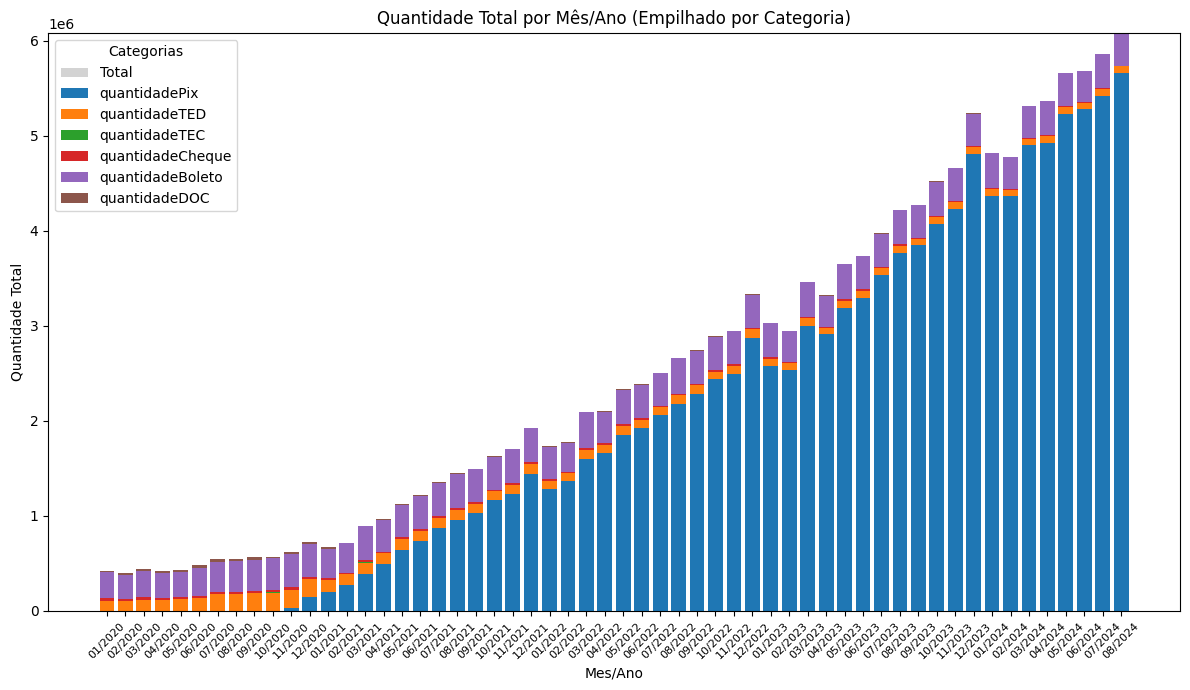

In [16]:
#Definição das colunas a serem plotadas neste gráfico
categorias = ['quantidadePix', 'quantidadeTED', 'quantidadeTEC',
              'quantidadeCheque', 'quantidadeBoleto', 'quantidadeDOC']

# Definição do tamanho do gráfico
plt.figure(figsize=(12, 7))

# Especificação do gráfico de barras, eixo utilizando coluna MesAno e colunas especificadas a serem plotadas).
plt.bar(df_quantidade['MesAno'], df_quantidade[categorias].sum(axis=1), label='Total', color='lightgrey')

#Aqui uma criação de variável para que as colunas fiquem estacadas uma acima da outra.
bottom_values = [0] * len(df_quantidade)

#For utilizado para plotar cada coluna, utilizando o eixo x, a quantidade no valor y, e a posição da barra.
for categoria in categorias:
    plt.bar(df_quantidade['MesAno'], df_quantidade[categoria],
            bottom=bottom_values, label=categoria)
    bottom_values = [bottom + val for bottom, val in zip(bottom_values, df_quantidade[categoria])]

#Criação de título do gráfico e título dos eixos
plt.title('Quantidade Total por Mês/Ano (Empilhado por Categoria)')
plt.xlabel('Mes/Ano')
plt.ylabel('Quantidade Total')

#Criação da legenda das colunas
plt.legend(title='Categorias')

#Rotação do eixo x para melhor visualização.
plt.xticks(rotation=45, fontsize = 8)

# Exibe o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

É perceptível visualmente neste gráfico observar que a quantidade de transações de todos os métodos, com exceção do PIX, seguiu constante mês a mês. No entando, o PIX, a partir do final de 2020 cresceu significativamente em praticamente todos os meses, exponenciando em larga escala a quantidade total de transações realizadas no Brasil. Em número de transações, o PIX acelerou a quantidade de movimentações financeiras realizadas, sendo que em praticamente 4 anos de existência, multiplicou por 6 vezes a quantidade total de transações.

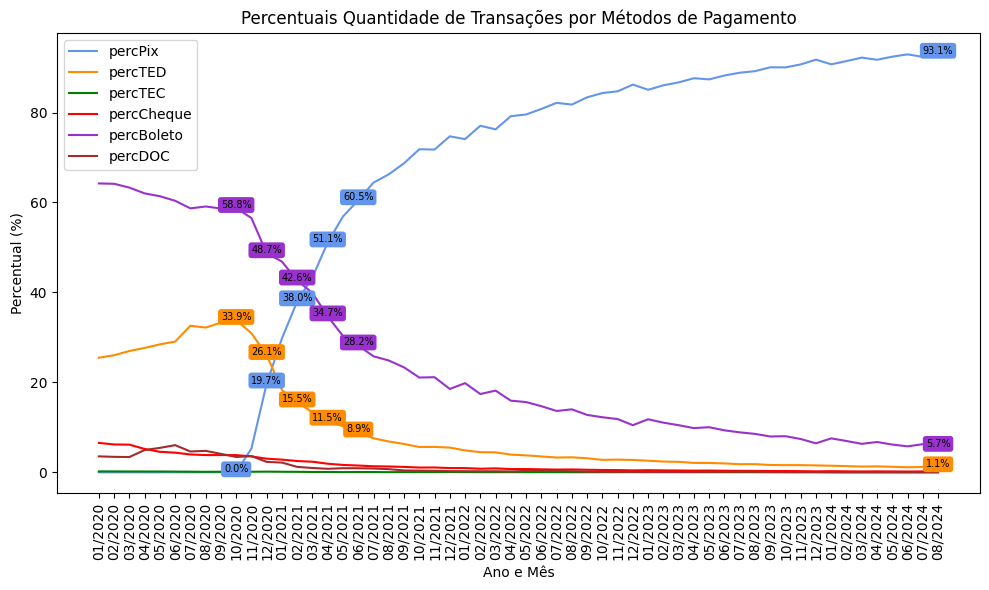

In [17]:
# Definindo o eixo x e as colunas que serão plotadas
x = df_quantidade['MesAno']
columns_to_plot = ['percPix', 'percTED', 'percTEC', 'percCheque', 'percBoleto', 'percDOC']
colors = ['cornflowerblue', 'darkorange', 'green', 'red', 'darkorchid', 'brown']

#Seleção de alguns meses em específico para inserção de rótulo de dados.
months_to_include = ['10/2020', '12/2020', '02/2021', '04/2021','06/2021','08/2024']
mask = x.isin(months_to_include)
x_filtered = x[mask]
df_filtered = df_quantidade[mask]

plt.figure(figsize=(10,6))


for i, col in enumerate(columns_to_plot):
    plt.plot(x, df_quantidade[col], label=col, color = colors[i])

    # Adicionando anotações para os pontos desejados apenas nas colunas especificadas
    if col in ['percPix', 'percBoleto', 'percTED']:
      for (x_val, y_val) in zip(x_filtered, df_filtered[col]):
            plt.annotate(
                f"{y_val:.1f}%",
                (x_val, y_val),
                textcoords="offset points",
                xytext=(0, 0),
                ha='center',
                fontsize=7,
                bbox=dict(boxstyle="round,pad=0.3",
                          edgecolor='none',
                          facecolor=plt.gca().lines[columns_to_plot.index(col)].get_color()))

# Adicionando título e rótulos
plt.title('Percentuais Quantidade de Transações por Métodos de Pagamento')
plt.xlabel('Ano e Mês')
plt.ylabel('Percentual (%)')

# Exibindo a legenda
plt.legend()

# Rotacionando o eixo x para melhor visualização, se necessário
plt.xticks(rotation=90)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

Neste gráfico vemos o crescimento percentual na quantidade de transações logo no ínicio da implementação do PIX. Em outubro de 2021, Boleto era a modalidade líder, com 58% das transações e TED com 34% e PIX 0%. Após apenas 6 meses, o Pix se consolida como principal modalidade financeira, atingindo 51% de todas as transações, enquanto Boleto cai para 34% e Ted para 15%. No último mês, em agosto de 2024, percebemos como em quantidade de transações o PIX se consolidou atingindo 93%, enquanto Boleto com 5,7% e TED 1,1%.

## VALOR TOTAL DAS TRANSAÇÕES

In [18]:
print(df_valor.columns)

Index(['MesAno', 'valorPix', 'valorTED', 'valorTEC', 'valorCheque',
       'valorBoleto', 'valorDOC', 'valorTotal', 'percPix', 'percTED',
       'percTEC', 'percCheque', 'percBoleto', 'percDOC'],
      dtype='object')


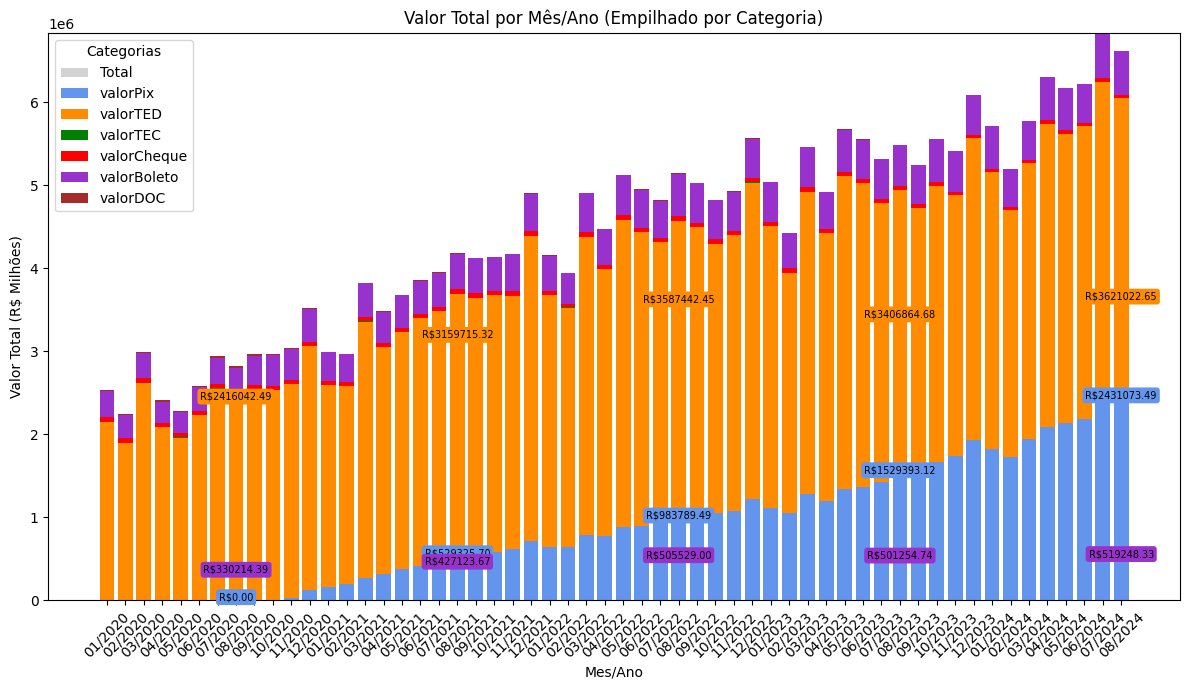

In [19]:
#Definição das colunas a serem plotadas neste gráfico
categorias = ['valorPix', 'valorTED', 'valorTEC',
              'valorCheque', 'valorBoleto', 'valorDOC']

months_to_include = ['08/2020', '08/2021', '08/2022', '08/2023','08/2024']
mask = df_valor['MesAno'].isin(months_to_include)
x_filtered = df_valor['MesAno'][mask]
df_filtered = df_valor[mask]
colors = ['cornflowerblue', 'darkorange', 'green', 'red', 'darkorchid', 'brown']
# Definição do tamanho do gráfico
plt.figure(figsize=(12, 7))

# Especificação do gráfico de barras, eixo utilizando coluna MesAno e colunas especificadas a serem plotadas).
plt.bar(df_valor['MesAno'], df_valor[categorias].sum(axis=1), label='Total', color='lightgrey')

#Aqui uma criação de variável para que as colunas fiquem estacadas uma acima da outra.
bottom_values = [0] * len(df_valor)

#For utilizado para plotar cada coluna, utilizando o eixo x, a quantidade no valor y, e a posição da barra.
for i, categoria in enumerate(categorias):
    plt.bar(df_valor['MesAno'], df_valor[categoria],
            bottom=bottom_values, label=categoria, color = colors[i])
    bottom_values = [bottom + val for bottom, val in zip(bottom_values, df_valor[categoria])]

    # Adicionando anotações para os pontos desejados apenas nas colunas especificadas
    if categoria in ['valorPix', 'valorBoleto', 'valorTED']:

      for (x_val, y_val) in zip(x_filtered, df_filtered[categoria]):
            plt.annotate(
                f"R${y_val:.2f}",
                (x_val, y_val),
                textcoords="offset points",
                xytext=(0, 0),
                ha='center',
                fontsize=7,
                bbox=dict(boxstyle="round,pad=0.3",
                          edgecolor='none',
                          facecolor=colors[i]))

#Criação de título do gráfico e título dos eixos
plt.title('Valor Total por Mês/Ano (Empilhado por Categoria)')
plt.xlabel('Mes/Ano')
plt.ylabel('Valor Total (R$ Milhões)')

#Criação da legenda das colunas
plt.legend(title='Categorias')

#Rotação do eixo x para melhor visualização.
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

Através deste gráfico, é possível perceber que apesar do crescimento do PIX, em valor monetário total o TED ainda é muito mais representativo. Além disso, apesar do boleto e TED terem caído percentualmente, o boleto segue sua média com uma leve crescente e o TED ainda subindo significativamente, atingindo 3,6 trilhões de reais movimentados em agosto de 2024. Enquanto isso, o boleto em 0,5 trilhões e o PIX com 2,4 trilhões,  subindo quase 1 trilhão desde agosto do ano passado.

Observação: O ideal seria aque cada rótulo de dado ficasse na base da barra da categoria respectiva. No entando, o padrão da função no matplotlib posiciona a legenda no seu valor númerico respectivo no eixo Y. Não consegui contornar esse problema, apesar de entender que a sua posição Y seria na verdade uma altura cumulativa das barras. No entanto, a cor do fundo para cada rótulo auxilia na identificação de qual categoria aquele valor representa.

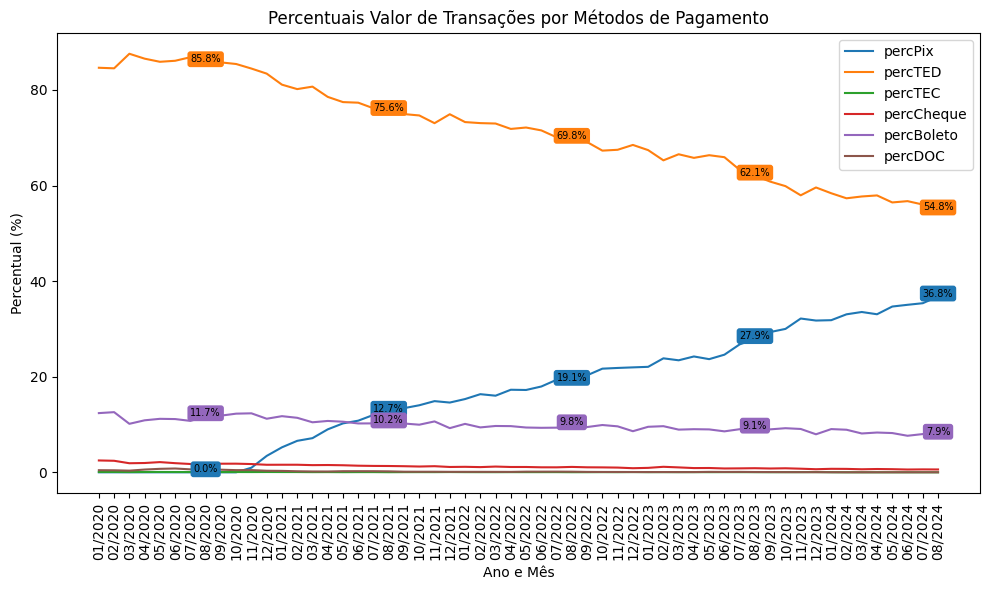

In [20]:
# Definindo o eixo x e as colunas que serão plotadas
x = df_valor['MesAno']
columns_to_plot = ['percPix', 'percTED', 'percTEC', 'percCheque', 'percBoleto', 'percDOC']

months_to_include = ['08/2020', '08/2021', '08/2022', '08/2023','08/2024']
mask = x.isin(months_to_include)
x_filtered = x[mask]
df_filtered = df_valor[mask]

plt.figure(figsize=(10,6))


for col in columns_to_plot:
    plt.plot(x, df_valor[col], label=col)

    # Adicionando anotações para os pontos desejados apenas nas colunas especificadas
    if col in ['percPix', 'percBoleto', 'percTED']:
      for (x_val, y_val) in zip(x_filtered, df_filtered[col]):
            plt.annotate(
                f"{y_val:.1f}%",
                (x_val, y_val),
                textcoords="offset points",
                xytext=(0, 0),
                ha='center',
                fontsize=7,
                bbox=dict(boxstyle="round,pad=0.3",
                          edgecolor='none',
                          facecolor=plt.gca().lines[columns_to_plot.index(col)].get_color()))

# Adicionando título e rótulos
plt.title('Percentuais Valor de Transações por Métodos de Pagamento')
plt.xlabel('Ano e Mês')
plt.ylabel('Percentual (%)')

# Exibindo a legenda
plt.legend()

# Rotacionando o eixo x para melhor visualização, se necessário
plt.xticks(rotation=90)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

Aqui podemos perceber como o crescimento do PIX, em percentual monetário é mais tímido do que na quantidade de transações, apesar de ainda ter um crescimento significativo. Boleto, a modalidade que era a mais utilizada até início de 2021, perdeu apenas 4% no montante total nesses 4 anos. A modalidade TED, ainda que dominante caiu de 85% para 55%, mas ainda se mantendo a mais utilizada. O PIX com um crescimento médio de quase 10% ao ano, tende a atingir 40% do volume financeiro até o final do ano de 2024.

## TICKET MÉDIO

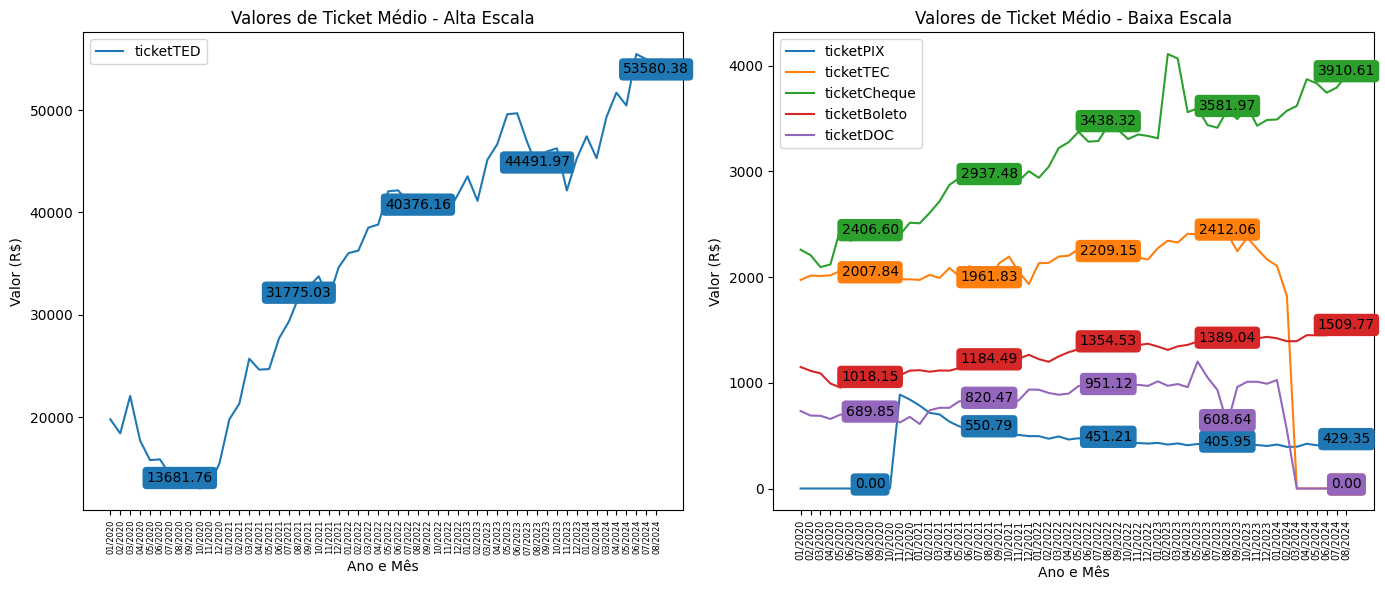

In [35]:
# Definindo o eixo x e as colunas que serão plotadas
x = df_ticket['MesAno']
columns_to_plot_high = ['ticketTED']
columns_to_plot_low = ['ticketPIX', 'ticketTEC', 'ticketCheque', 'ticketBoleto', 'ticketDOC']


months_to_include = ['08/2020', '08/2021', '08/2022', '08/2023','08/2024']
mask = x.isin(months_to_include)
x_filtered = x[mask]
df_filtered = df_ticket[mask]

# Criando subplots - dois gráficos no mesmo espaço
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

# Primeiro gráfico para a coluna de alta escala
for col in columns_to_plot_high:
    ax1.plot(x, df_ticket[col], label=col)
    line_color = ax1.lines[-1].get_color()
    for (x_val, y_val) in zip(x_filtered, df_filtered[col]):
          ax1.annotate(
              f"{y_val:.2f}",
              (x_val, y_val),
              textcoords="offset points",
              xytext=(0, 0),
              ha='center',
              fontsize=10,
              bbox=dict(boxstyle="round,pad=0.3",
                        edgecolor='none',
                        facecolor=line_color))

ax1.set_title('Valores de Ticket Médio - Alta Escala')
ax1.set_xlabel('Ano e Mês')
ax1.set_ylabel('Valor (R$)')
ax1.legend()
ax1.tick_params(axis='x', rotation=90, labelsize = 6)  # Rotacionando o eixo x

# Segundo gráfico para as colunas de baixa escala
for col in columns_to_plot_low:
    ax2.plot(x, df_ticket[col], label=col)
    for (x_val, y_val) in zip(x_filtered, df_filtered[col]):
          ax2.annotate(
              f"{y_val:.2f}",
              (x_val, y_val),
              textcoords="offset points",
              xytext=(0, 0),
              ha='center',
              fontsize=10,
              bbox=dict(boxstyle="round,pad=0.3",
                        edgecolor='none',
                        facecolor=plt.gca().lines[columns_to_plot_low.index(col)].get_color()))

ax2.set_title('Valores de Ticket Médio - Baixa Escala')
ax2.set_xlabel('Ano e Mês')
ax2.set_ylabel('Valor (R$)')
ax2.legend()
ax2.tick_params(axis='x', rotation=90,labelsize = 7)  # Rotacionando o eixo x

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo os gráficos
plt.show()


Na primeira plotagem deste gráfico, percebemos que o ticket médio para a modalidade TED era de uma escala bem maior que as outras. Por isso, foi separado em duas plotagens, segregando TED das outras modalidades. Percebemos portanto que o uso do TED é costumeiramente para transações financeiras, e o do PIX segue como a modalidade de ticket médio mais baixo. Apesar do seu extenso crescimento de utilizações durante os 4 anos, o ticket médio de PIX se manteve em torno de 400 reais, enquanto todas as outras transações com valores significativos acima. Foram plotadas nos gráficos todas as médias nos meses de agosto de 2020 a 2024.

# PRÉ PROCESSAMENTO

Vamos realizado a normalização utilizando o MinMaxScaler da biblioteca SciKitLearn nos valores númericos de quantidade e valor das modalidades.

Criaremos uma cópia dos dataframes df_quantidade e df_valor sem as colunas de percentual para tais.

Para o dataframe com os valores de ticket médio, iremos utilizar a padronização de Z-Score Normalizaiton, com intuito de entender suas flutuações com o passar dos meses, modalidade a modalidade.

## QUANTIDADE DE TRANSAÇÕES

In [22]:
print(df_quantidade.columns)

Index(['MesAno', 'quantidadePix', 'quantidadeTED', 'quantidadeTEC',
       'quantidadeCheque', 'quantidadeBoleto', 'quantidadeDOC',
       'quantidadeTotal', 'percPix', 'percTED', 'percTEC', 'percCheque',
       'percBoleto', 'percDOC'],
      dtype='object')


In [23]:
colunas_para_normalizar = ['quantidadePix', 'quantidadeTED', 'quantidadeTEC','quantidadeCheque', 'quantidadeBoleto', 'quantidadeDOC','quantidadeTotal']

df_quantidade_pre_processamento = df_quantidade.copy()
df_quantidade_pre_processamento = df_quantidade_pre_processamento[colunas_para_normalizar]
# Criando uma instância do MinMaxScaler
scaler = MinMaxScaler()

# Aplicando o MinMaxScaler nas colunas selecionadas
df_quantidade_pre_processamento[colunas_para_normalizar] = scaler.fit_transform(df_quantidade_pre_processamento[colunas_para_normalizar])

In [24]:
Meses_Agosto = [7, 19, 31, 43, 55] # valores de índice específicos para os meses de agosto na amostra inicial
Valores_Agosto = df_quantidade_pre_processamento.iloc[Meses_Agosto]
print(Valores_Agosto)

    quantidadePix  quantidadeTED  quantidadeTEC  quantidadeCheque  \
7        0.000000       0.867044       0.452199          0.628799   
19       0.169726       0.275032       0.308653          0.502680   
31       0.385060       0.193770       0.337493          0.397216   
43       0.665359       0.099553       0.470383          0.191921   
55       1.000000       0.030555       0.000000          0.020271   

    quantidadeBoleto  quantidadeDOC  quantidadeTotal  
7           0.557234       0.899095         0.027012  
19          0.842197       0.346985         0.185503  
31          0.941327       0.230085         0.399264  
43          0.844313       0.180578         0.673054  
55          0.711208       0.000000         1.000000  


Foram printados acima os valores encontrados para o agosto de todos os anos, afim de termos comparativos anualmente.
Aplicando o pré processamento de normalização nas colunas de quantidades, podemos comparar modalidade a modalidade como o valor de cada mês está comparado a sua média, máximo e mínimo. Assim, entendendo como decorreu a variação com o passar dos meses. Por exemplo, o PIX com valor 0 nos meses iniciais, onde ainda não era utilizado. Já no último mês obteve seu maior valor, registrado com valor normlizado 1.
Ou seja, nesta representação o valor 0 identifica seus mínimos valores, enquanto o valor 1 o máximo. Em todos os outros campos decimais internamente, a sua proporção normalizada. Assim é possível entender a flutuação das modalidades com o tempo, em termos de crescimento ou queda.

## VALOR DAS TRANSAÇÕES

In [25]:
print(df_valor.columns)

Index(['MesAno', 'valorPix', 'valorTED', 'valorTEC', 'valorCheque',
       'valorBoleto', 'valorDOC', 'valorTotal', 'percPix', 'percTED',
       'percTEC', 'percCheque', 'percBoleto', 'percDOC'],
      dtype='object')


In [26]:
colunas_para_normalizar = ['valorPix', 'valorTED', 'valorTEC', 'valorCheque','valorBoleto', 'valorDOC', 'valorTotal']

df_valor_pre_processamento = df_valor.copy()
df_valor_pre_processamento = df_valor_pre_processamento[['valorPix', 'valorTED', 'valorTEC', 'valorCheque','valorBoleto', 'valorDOC', 'valorTotal']]
# Criando uma instância do MinMaxScaler
scaler = MinMaxScaler()

# Aplicando o MinMaxScaler nas colunas selecionadas
df_valor_pre_processamento[colunas_para_normalizar] = scaler.fit_transform(df_valor_pre_processamento[colunas_para_normalizar])

In [27]:
Meses_Agosto = [7, 19, 31, 43, 55] # valores de índice específicos para os meses de agosto na amostra inicial
Valores_Agosto = df_valor_pre_processamento.iloc[Meses_Agosto]
print(Valores_Agosto)

    valorPix  valorTED  valorTEC  valorCheque  valorBoleto  valorDOC  \
7   0.000000  0.269532  0.429793     0.544864     0.257626  0.879711   
19  0.217733  0.654008  0.286637     0.712755     0.590009  0.403784   
31  0.404673  0.875142  0.352930     0.819167     0.858927  0.310386   
43  0.629102  0.781784  0.537081     0.409133     0.844267  0.155885   
55  1.000000  0.892503  0.000000     0.114089     0.905982  0.000000   

    valorTotal  
7     0.125042  
19    0.422038  
31    0.631403  
43    0.706992  
55    0.951110  


Os valores encontrados para montante transacionado seguem algumas tendências da quantidade. O Valor Pix segue com seu maior resultado no último mês. As modalidades TEC e DOC desapareceram da utilização. Cheque segue caindo apesar de ter tido seu ápice em 2022. E mais significativo, as modalidades TED e Boleto apesar de em quantidade estarem decaíndo, em montante transacionado seguem expressivas em 2024, tendo seus maiores valores no último ano olhando apenas para os meses de agosto.

## TICKET MÉDIO

In [28]:
colunas_ticket_medio = ['ticketPIX', 'ticketTED', 'ticketTEC', 'ticketCheque','ticketBoleto', 'ticketDOC']
df_ticket_pre_processamento = df_ticket.copy()
scaler = StandardScaler()
df_ticket_pre_processamento[colunas_ticket_medio] = scaler.fit_transform(df_ticket_pre_processamento[colunas_ticket_medio])


In [29]:
Meses_Agosto = [7, 19, 31, 43, 55] # valores de índice específicos para os meses de agosto na amostra inicial
Valores_Agosto = df_ticket_pre_processamento.iloc[Meses_Agosto]
print(Valores_Agosto)

     MesAno  ticketPIX  ticketTED  ticketTEC  ticketCheque  ticketBoleto  \
7   08/2020  -1.862749  -1.679314   0.132770     -1.338798     -1.616860   
19  08/2021   0.677480  -0.259329   0.064967     -0.335367     -0.490358   
31  08/2022   0.218246   0.415700   0.429419      0.611280      0.661167   
43  08/2023   0.009485   0.738714   0.728435      0.882800      0.894806   
55  08/2024   0.117389   1.451986  -2.826061      1.503990      1.712438   

    ticketDOC  ticketTotal  
7   -0.225814  5132.412265  
19   0.216133  2882.343453  
31   0.658232  1928.469765  
43  -0.500612  1299.558519  
55  -2.560050  1086.573346  


Para o ticket médio, utilizamos outra técnica de normalização, focada em comparativos com o desvio padrão. Assim podemos entender como está a variação mês a mês em relação ao valor original, média e desvião de cada modalidade.
Valores próximos de 0 indicam proximidada a média, enquanto positivos valores acima e valores normalizados negativos significam que aquele valor encontrado estava abaixo da média.

Ou seja, para o Pix é perceptível que não há um crescimento de valor do ticket médio apesar do crescimento do uso da modalidade. Para o TED, o crescimento é significativo, pois apesar do percentual de uso ter caído, seu volume financeiro e padrão de transação é constante. Inclusive, por provavelmente as transações de baixo custo terem sido dominadas pelo PIX, a média do TED subiu consideravalmente. O mesmo para cheque e boleto, apesar da baixa utilização.

# CONCLUSÕES FINAIS

Alguns questionamentos precisavam ser respondidos no ínicio do projeto. Em relação a meta de utilização do PIX: percebemos que a quantidade de transações utilizadas cresce mês a mês, no entanto são percebidas algumas barreiras nos padrões de uso. Transações financeiras de larga escala ainda são evitadas, mantendo as modalidades TED e Boleto com significativa participação no montante total transacionado. Ainda com o crescimento do PIX, o uso das dessas outras 2 modalidades não decai em números absolutos (quantidade e volume transacionado).

O ticket médio também é um excelente padrão para análise. Enquanto o PIX cresce em volumetria, seu ticket médio permanece constante. E com isso, ao 'roubar' transações de outras modalidades, essas modalidades tem seu ticket médio acrescido. Isto representa uma excelente característica em relação ao uso do PIX, sendo extremamente facilitado para transações rápidas, mas evitado para movimentações de alto valor.

Os dataframes gerados no pré processamento podem ser valiosos na geração de modelos no futuro. A agregação também de dados de população economicamente ativa e outros dados socioeconômicos podem ajudar na projeção dos próximos meses. As normalizações geradas também corroboram diversas análises observadas nos gráficos, como padrões de crescimento e flutuações.